# Libraries
We use some standard python packages and the libraries of scikit learn and keras. 

In [50]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical, Sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop,Adam
from keras.applications import VGG19, VGG16, ResNet50, ResNet152V2

import warnings
warnings.filterwarnings("ignore")

# Path

In [106]:
path = '../../landmark-recognition-2021/'
os.listdir(path)

['test', 'train', 'sample_submission.csv', 'train.csv']

# Load Data

In [107]:
train_data = pd.read_csv(path+'train.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')

In [108]:
train_data.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [109]:
samp_subm.head()

,id,landmarks
0,00084cdf8f600d00,137790 0.1
1,000b15b043eb8cf0,137790 0.1
2,0011a52f9b948fd2,137790 0.1
3,00141b8a5a729084,137790 0.1
4,0018aa4b92532b77,137790 0.1


In [119]:
print(train_data["landmark_id"].value_counts())
print("Moyenne : ",np.mean(train_data["landmark_id"].value_counts()))

138982    6272
126637    2231
20409     1758
83144     1741
113209    1135
          ... 
134114       2
148173       2
179663       2
199396       2
25033        2
Name: landmark_id, Length: 81313, dtype: int64
Moyenne :  19.436867413574706


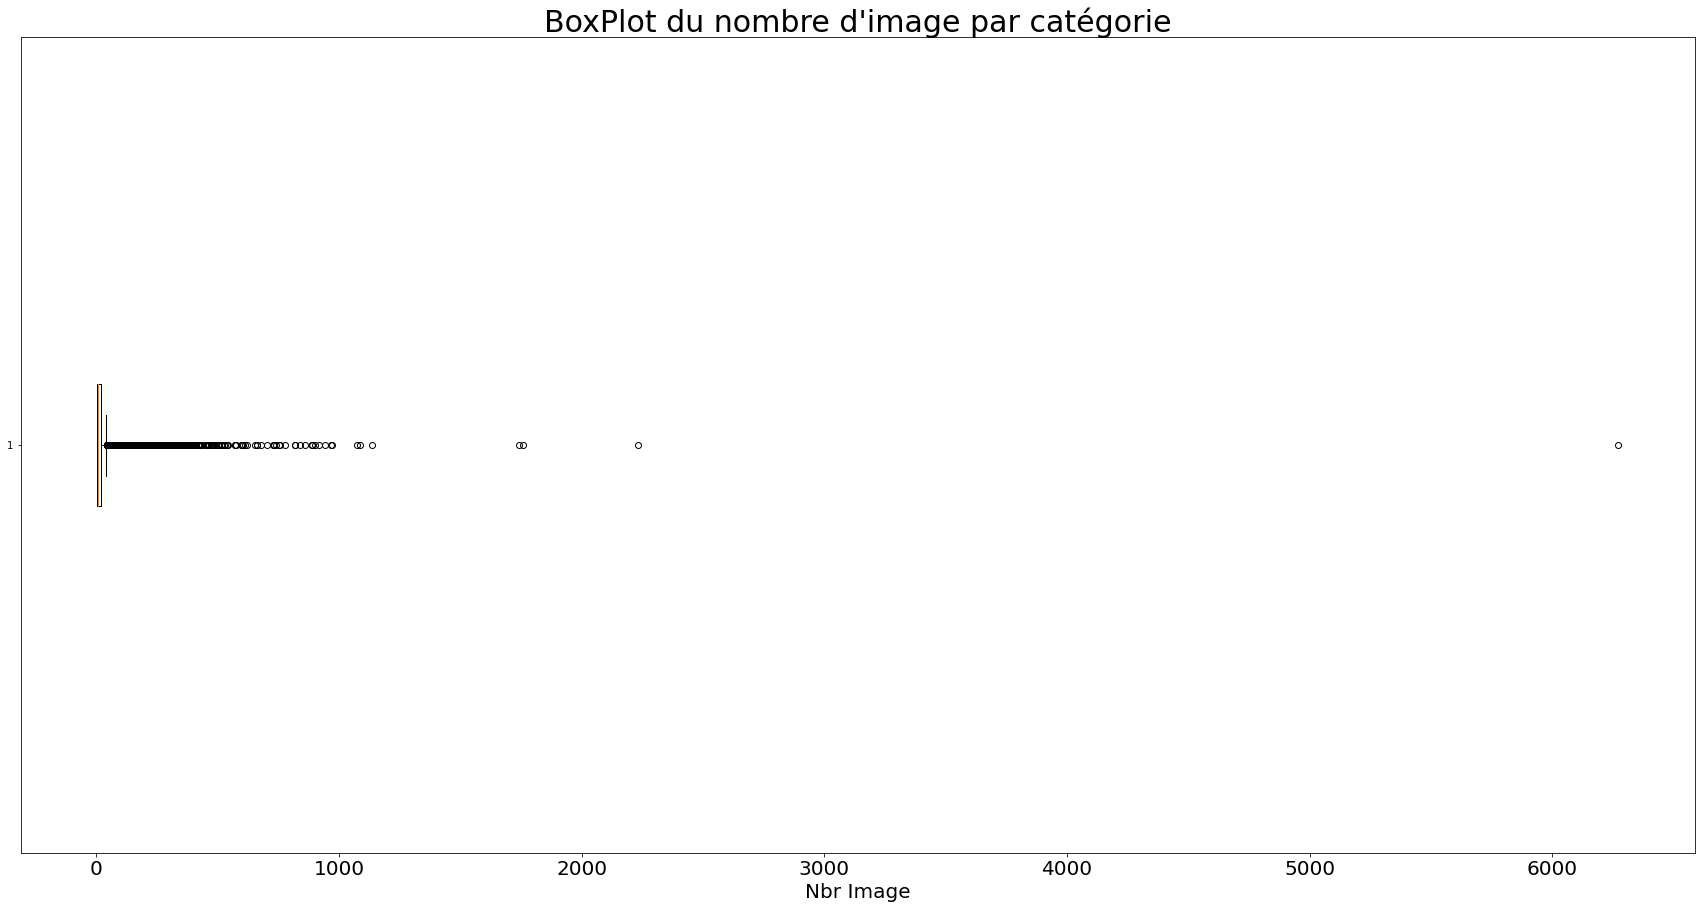

In [118]:
fig = plt.figure(figsize=(30, 15))
plt.boxplot(train_data["landmark_id"].value_counts(), vert=0)
plt.title("BoxPlot du nombre d'image par catégorie",fontsize=30)
plt.xticks(size=20)
plt.xlabel("Nbr Image",fontsize=20)
plt.show()

In [55]:
# We keep 10 classes
indexToUse = train_data["landmark_id"].value_counts()[1:11].index
train_data = train_data.query('landmark_id in @indexToUse')
train_data=train_data.replace([126637, 20409, 83144,113209,177870,194914,149980,139894,1924,176528], [0,1, 2, 3, 4,5,6,7,8,9])

train_data.reset_index(drop=True, inplace=True)

# Functions

In [56]:
def plot_examples(landmark_id=1):
    """ Plot 5 examples of images with the same landmark_id """
    
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = train_data[train_data['landmark_id']==landmark_id].index[i]
        image_id = train_data.loc[idx, 'id']
        file = image_id+'.jpg'
        subpath = '/'.join([char for char in image_id[0:3]])
        img = cv2.imread(path+'train/'+subpath+'/'+file)
        axs[i].imshow(img)
        axs[i].set_title('landmark_id: '+str(landmark_id))
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [57]:
def ImgToTreat(img, toDisplay=False):  
    """ Image processing (histogram equalization and blur)"""
    imgBlur = img
    try:
        locImg=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        # Egalisation histogramme
        imgEq = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
        imgEq[:, :, 0] = cv2.equalizeHist(imgEq[:, :, 0])
        imgEq = cv2.cvtColor(imgEq,cv2.COLOR_YCrCb2RGB)
        # Lissage bruit
        imgBlur = cv2.blur(imgEq,(2,2))
    except Exception as e:
        print(e)
        pass
    if(toDisplay):
        fig = plt.figure(figsize=(30,15))
        plt.suptitle("Traitement image",fontsize=30)
        plt.subplot(1,3,1)
        plt.imshow(locImg)
        plt.title("Image de base",fontsize=20)
        plt.subplot(1,3,2)
        plt.imshow(imgEq)
        plt.title("Image de Egaliser",fontsize=20)
        plt.subplot(1,3,3)
        plt.imshow(imgBlur)
        plt.title("Image lissage bruit",fontsize=20)
        
        plt.show()
    return imgBlur

# Overview
First we look on the size of the dataset:

In [58]:
print('Samples train:', len(train_data))
print('Samples test:', len(samp_subm))

Samples train: 12827
Samples test: 10345


In [59]:
train_data.head()

,id,landmark_id
0,00061e23ce736fa9,8
1,0060992db5cc819f,8
2,008315aa634e14b9,8
3,008e6817cf364cb6,8
4,00bad7a508ee6666,8


There are 81313 unique classes:

In [60]:
len(train_data['landmark_id'].unique())

10

For each test image, we have to predict one landmark label and a corresponding confidence score. 

In [61]:
samp_subm.head()

,id,landmarks
0,00084cdf8f600d00,137790 0.1
1,000b15b043eb8cf0,137790 0.1
2,0011a52f9b948fd2,137790 0.1
3,00141b8a5a729084,137790 0.1
4,0018aa4b92532b77,137790 0.1


# Find Image
We consider the first image of the train data set and plot it. The first 3 characters ares used for the subpath which is the location of the image. 

In [62]:
train_data.head()

,id,landmark_id
0,00061e23ce736fa9,8
1,0060992db5cc819f,8
2,008315aa634e14b9,8
3,008e6817cf364cb6,8
4,00bad7a508ee6666,8


In [63]:
image_id = train_data.loc[0, 'id']
file = image_id+'.jpg'
subpath = '/'.join([char for char in image_id[0:3]]) 

In [64]:
file

'00061e23ce736fa9.jpg'

In [65]:
subpath

'0/0/0'

Is the file located in the subpath?

In [66]:
file in os.listdir(path+'train/'+subpath)

True

In [67]:
path

'../../landmark-recognition-2021/'

Plot the image:

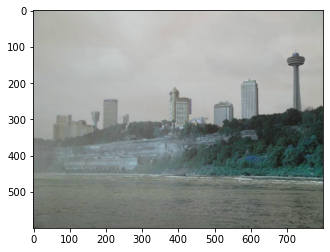

In [68]:
img = cv2.imread(path+'train/'+subpath+'/'+file)
plt.imshow(img)
plt.show()

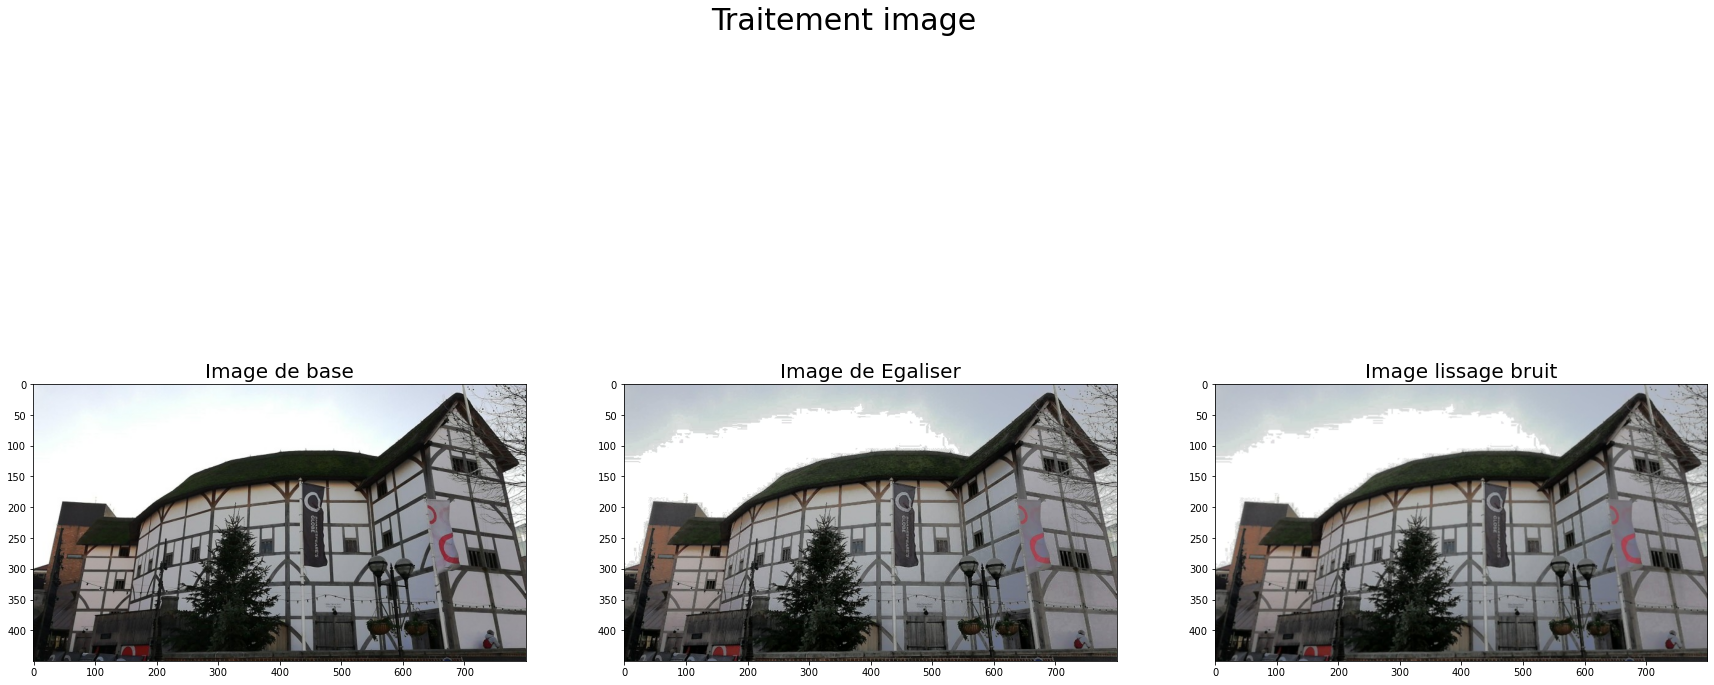

In [69]:
imgTest = ("../../1112e94d6ea56fdc.jpg")
imgTest = cv2.imread(imgTest)
test = ImgToTreat(imgTest,True)

Look on the image shape:

In [70]:
img.shape

(600, 800, 3)

# Plot Some Examples
We plot some examples of images with the same **landmark_id** in a row.

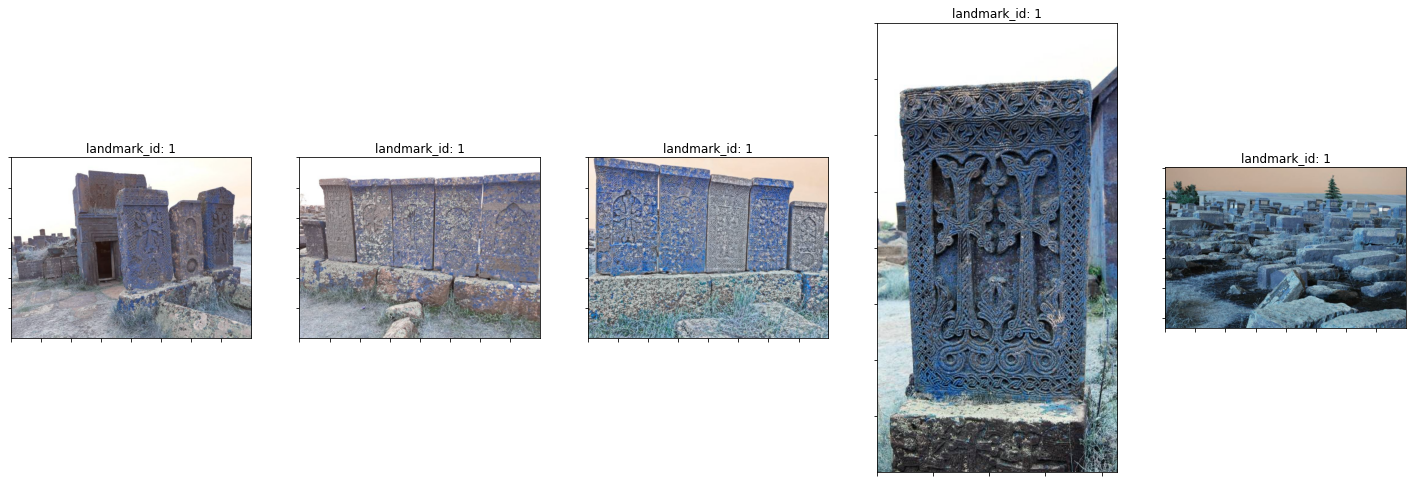

In [71]:
plot_examples(landmark_id = 1)

# Split Data
We define train, validation and test data.

In [72]:
train_data.index[0:3]

RangeIndex(start=0, stop=3, step=1)

In [73]:
list(train_data.index)[:15]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [74]:
list_IDs_trainA, list_IDs_valA = train_test_split(list(train_data.index)[:15], test_size=0.33, random_state=2021)
print('---- list_IDs_trainA -----')
print(list_IDs_trainA)
print('---list_IDs_valA-----')
print(list_IDs_valA)
print('-----------')
list_IDs_testA = list(samp_subm.index)[:15]
print('---- list_IDs_testA-----')
print(list_IDs_testA)
print('-----------')

---- list_IDs_trainA -----
[1, 10, 14, 8, 13, 6, 0, 9, 5, 4]
---list_IDs_valA-----
[3, 11, 7, 2, 12]
-----------
---- list_IDs_testA-----
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
-----------


In [75]:
train_data.iloc[train_data.index[0:3]]

,id,landmark_id
0,00061e23ce736fa9,8
1,0060992db5cc819f,8
2,008315aa634e14b9,8


In [76]:
#500000
list_IDs_train, list_IDs_val = train_test_split(list(train_data.index)[:100000], test_size=0.33, random_state=2021)
list_IDs_test = list(samp_subm.index)

In [77]:
print('Number train samples:', len(list_IDs_train))
print('Number val samples:', len(list_IDs_val))
print('Number test samples:', len(list_IDs_test))

Number train samples: 8594
Number val samples: 4233
Number test samples: 10345


# Data Generator

We use a data generator to load the data on demand.

In [78]:
img_size = 32
img_channel = 3
batch_size = 64

num_classes = len(train_data['landmark_id'].value_counts())

In [79]:
num_classes

10

# DataGenerator

In [93]:
class DataGenerator(Sequence):
    def __init__(self, path, list_IDs, data, img_size, img_channel, batch_size):
        self.path = path
        self.list_IDs = list_IDs
        self.data = data
        self.img_size = img_size
        self.img_channel = img_channel
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.list_IDs))
        
    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
            
    
    def __data_generation(self, list_IDs_temp):
        X = np.zeros((self.batch_size, self.img_size, self.img_size, self.img_channel))
        y = np.zeros((self.batch_size, 1), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            
            image_id = self.data.loc[ID, 'id']
            file = image_id+'.jpg'
            subpath = '/'.join([char for char in image_id[0:3]]) 
            
            img = cv2.imread(self.path+subpath+'/'+file)
            img = ImgToTreat(img,False)
            img = cv2.resize(img, (self.img_size, self.img_size))
            X[i, ] = img/255
            if self.path.find('train')>=0:
                y[i, ] = self.data.loc[ID, 'landmark_id']
            else:
                y[i, ] = 0
        return X, y

Use the DataGenerator class to define the data generators for train, validation and test data:

In [94]:
train_generator = DataGenerator(path+'train/', list_IDs_train, train_data, img_size, img_channel, batch_size)
val_generator = DataGenerator(path+'train/', list_IDs_val, train_data, img_size, img_channel, batch_size)
test_generator = DataGenerator(path+'test/', list_IDs_test, samp_subm, img_size, img_channel, batch_size)

In [95]:
train_generator.data[:5]

,id,landmark_id
0,00061e23ce736fa9,8
1,0060992db5cc819f,8
2,008315aa634e14b9,8
3,008e6817cf364cb6,8
4,00bad7a508ee6666,8


In [96]:
# data_generation(list_IDs_train)


# Model

Load pretrained model:

In [97]:
weights='imagenet'
conv_base = ResNet50(weights=weights,
                     include_top=False,
                     input_shape=(img_size, img_size, img_channel))
conv_base.trainable = True

Define Model

In [98]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = Adam(lr=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [99]:
epochs = 5

In [100]:
history = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs = epochs, workers=4)

Epoch 1/5
135/135 [==============================] - 385s 3s/step - loss: 3.0122 - sparse_categorical_accuracy: 0.2541 - val_loss: 17.2523 - val_sparse_categorical_accuracy: 0.0989
Epoch 2/5
135/135 [==============================] - 331s 2s/step - loss: 0.9595 - sparse_categorical_accuracy: 0.7008 - val_loss: 21.5788 - val_sparse_categorical_accuracy: 0.1812
Epoch 3/5
135/135 [==============================] - 332s 2s/step - loss: 0.4406 - sparse_categorical_accuracy: 0.8775 - val_loss: 67.6952 - val_sparse_categorical_accuracy: 0.1810
Epoch 4/5
135/135 [==============================] - 330s 2s/step - loss: 0.1853 - sparse_categorical_accuracy: 0.9473 - val_loss: 26.2197 - val_sparse_categorical_accuracy: 0.1747
Epoch 5/5
135/135 [==============================] - 364s 3s/step - loss: 0.0965 - sparse_categorical_accuracy: 0.9866 - val_loss: 3.6549 - val_sparse_categorical_accuracy: 0.1702


In [101]:
print("Train done")

Train done


In [102]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


In [103]:
history.history['loss']

[2.357109546661377,
 0.9514253735542297,
 0.42782798409461975,
 0.20006220042705536,
 0.09229586273431778]

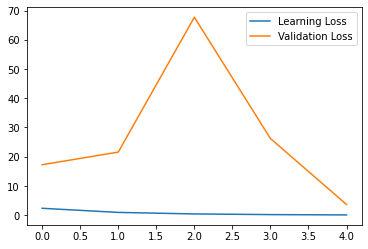

In [104]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Learning Loss","Validation Loss"],fontsize=10)

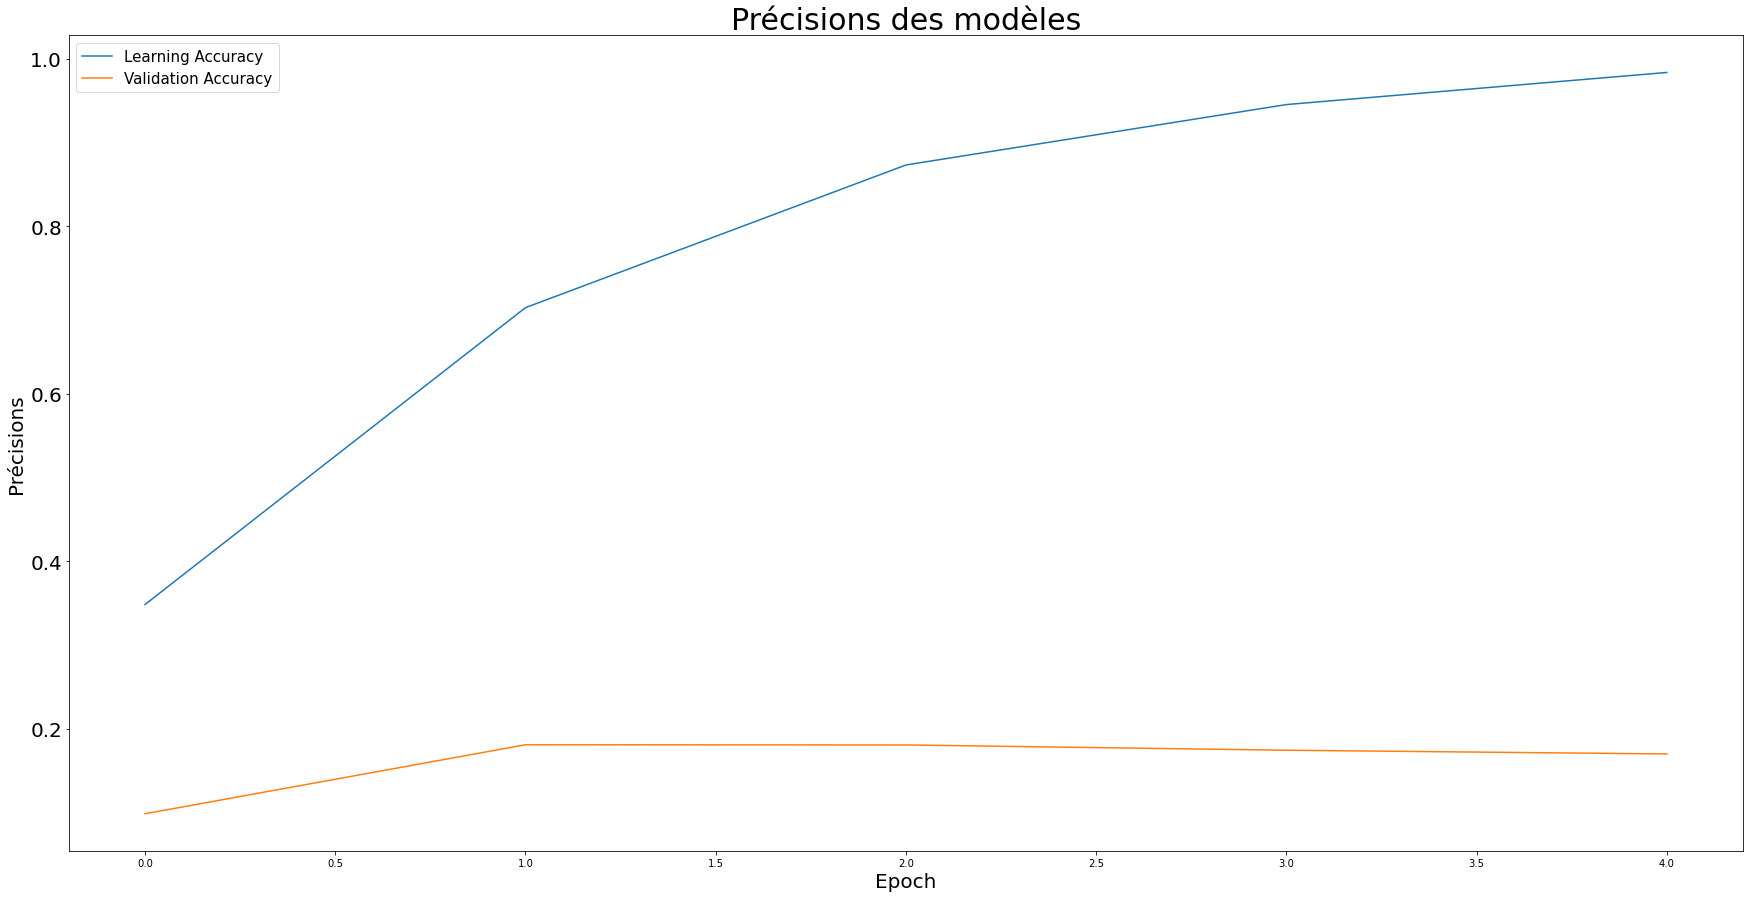

In [105]:
fig = plt.figure(figsize=(30, 15))
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("Précisions des modèles",fontsize=30)
plt.yticks(size=20)
plt.ylabel("Précisions",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(["Learning Accuracy","Validation Accuracy"],fontsize=15)
plt.show()

# Other model

In [114]:
weights='imagenet'
my_conv_base = ResNet152V2(weights=weights,
                     include_top=False,
                     input_shape=(img_size, img_size, img_channel))
my_conv_base.trainable = True

In [115]:
model = Sequential()
model.add(my_conv_base)
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes10, activation='softmax'))

model.compile(optimizer = Adam(lr=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 1, 1, 2048)        58331648  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                20490     
Total params: 58,352,138
Trainable params: 58,208,394
Non-trainable params: 143,744
_________________________________________________________________


In [116]:
history_res = my_resnet152_model.fit(train_generator10,
                              validation_data=val_generator10,
                              epochs = 10)

Epoch 1/10
135/135 [==============================] - 1356s 10s/step - loss: 1.2596 - accuracy: 0.1320 - val_loss: 1.7307 - val_accuracy: 0.1366
Epoch 2/10
135/135 [==============================] - 798s 6s/step - loss: 1.2342 - accuracy: 0.1328 - val_loss: 1.7455 - val_accuracy: 0.1328
Epoch 3/10
135/135 [==============================] - 685s 5s/step - loss: 1.2155 - accuracy: 0.1317 - val_loss: 1.7601 - val_accuracy: 0.1353
Epoch 4/10
135/135 [==============================] - 82s 608ms/step - loss: 1.1878 - accuracy: 0.1317 - val_loss: 1.7712 - val_accuracy: 0.1326
Epoch 5/10
135/135 [==============================] - 84s 623ms/step - loss: 1.1683 - accuracy: 0.1303 - val_loss: 1.7861 - val_accuracy: 0.1350
Epoch 6/10
135/135 [==============================] - 103s 767ms/step - loss: 1.1498 - accuracy: 0.1318 - val_loss: 1.7963 - val_accuracy: 0.1323
Epoch 7/10
135/135 [==============================] - 117s 868ms/step - loss: 1.1311 - accuracy: 0.1309 - val_loss: 1.8178 - val_accu

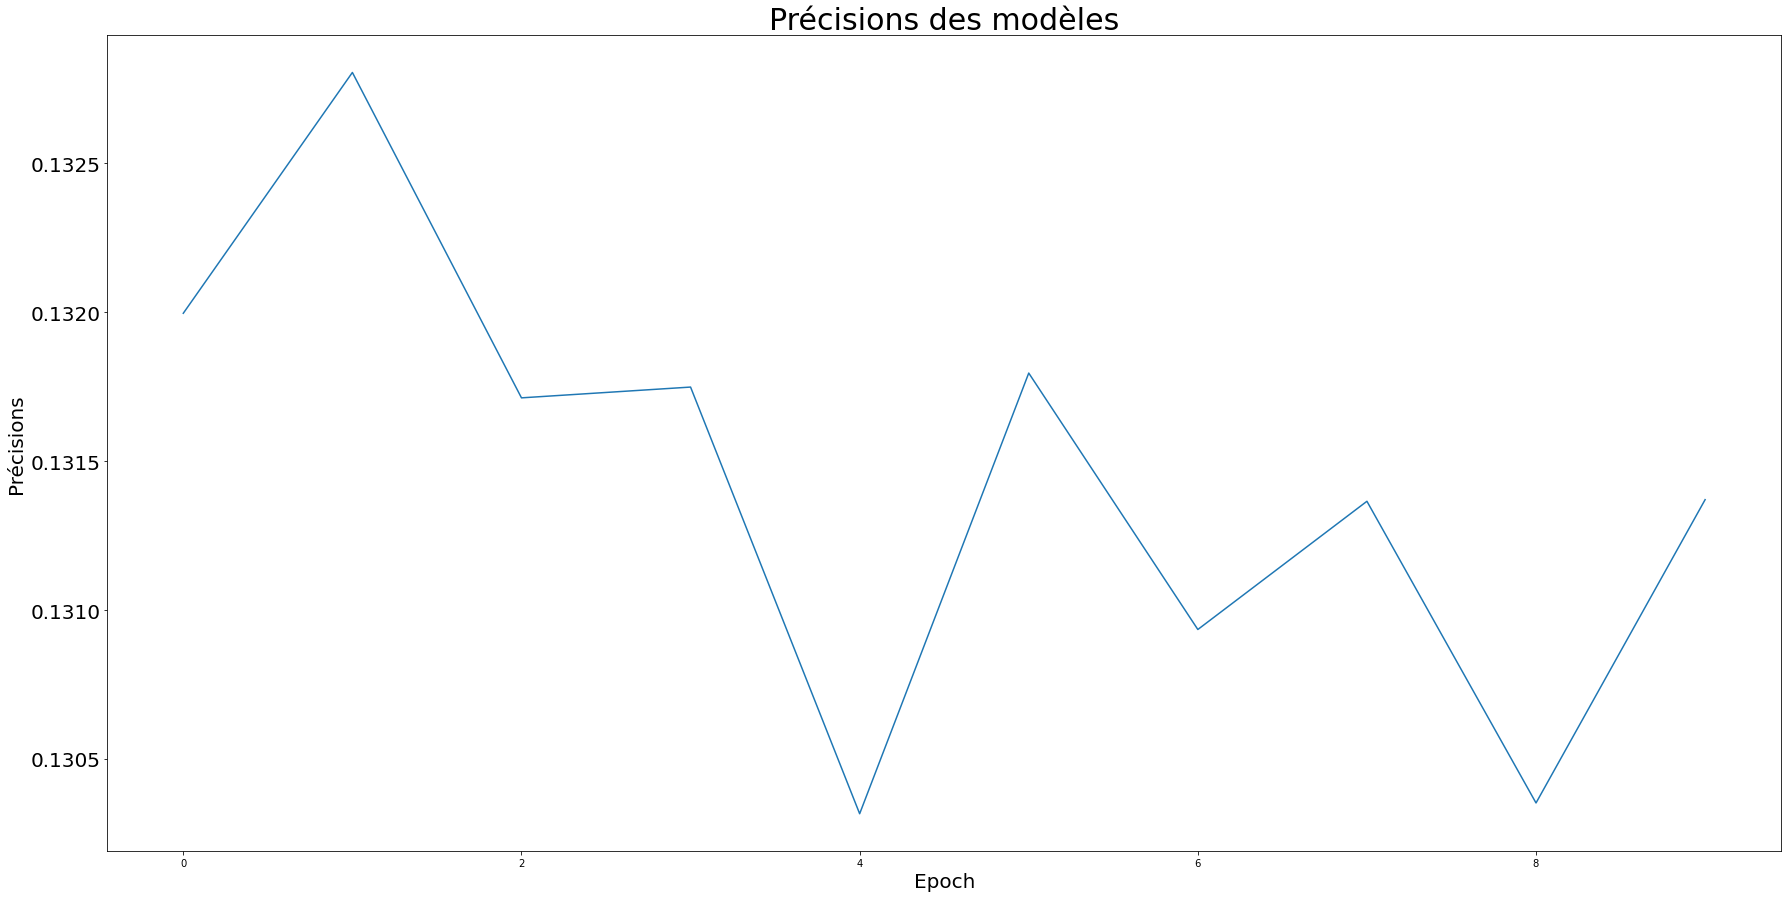

In [117]:
fig = plt.figure(figsize=(30, 15))
plt.plot(history_res.history["accuracy"])
plt.title("Précisions des modèles",fontsize=30)
plt.yticks(size=20)
plt.ylabel("Précisions",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.show()

# Predict Test Data

In [44]:
y_pred = model.predict_generator(test_generator, verbose=1)

162/162 [==============================] - 114s 701ms/step


In [45]:
y_pred.shape

(10368, 81313)

In [46]:
for i in range(len(samp_subm.index)):
    category = np.argmax(y_pred[i])
    score = y_pred[i][np.argmax(y_pred[i])].round(2)
    samp_subm.loc[i, 'landmarks'] = str(category)+' '+str(score)

In [47]:
samp_subm.head()

,id,landmarks
0,00084cdf8f600d00,7314 0.06
1,000b15b043eb8cf0,3732 0.09
2,0011a52f9b948fd2,3092 0.06
3,00141b8a5a729084,8834 0.02
4,0018aa4b92532b77,10419 0.07


# Export

In [48]:
samp_subm.to_csv('submission.csv', index=False)